In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import os, time, itertools, pickle, random, glob, imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import math

In [3]:
def dataset_load_album(datapath, labelpath, imgsize):
    """
    datapath 'jpeg' file of album image
    labelpath 'png' file of spectrogram 
    """
    datalist = os.listdir(datapath)
    datasize = len(datalist)
    
    data_ = np.zeros((datasize, imgsize, imgsize, 3))
    label_ = np.zeros((datasize, imgsize, imgsize, 3))
    nonelist = []
    for i, fname in enumerate(datalist):
        if glob.glob(os.path.join(labelpath, fname[:-4] + '*')):
        #f os.path.isfile(os.path.join(labelpath, fname[:-4] + 'png')):
            #print('there is file')
            img_d = Image.open(os.path.join(datapath, fname)
                              ).resize((imgsize, imgsize))
            img_l = Image.open(os.path.join(labelpath, fname[:-4]+'png')
                              ).convert('RGB').resize((imgsize, imgsize))
            data_[i] = np.asarray(img_d)
            label_[i] = np.asarray(img_l)
            
        else:
            nonelist.append(i)
            
    data = np.delete(data_, nonelist, 0)
    label = np.delete(label_, nonelist, 0)
    return data, label

In [10]:
# Load albumdata
img_size = 128

datapath = os.path.join('input', 'img')
samples, labels = dataset_load_album(
    'input/img', 'audio/spec', img_size)

samples = samples/255
labels = labels/255

input_dim = img_size * img_size * 3
num_sample = samples.shape[0]

In [5]:
class VariantionalAutoencoder(object):

    def __init__(self, input_dim =input_dim, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.input_dim = input_dim

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, self.input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f0 = fc(self.x, 1024, scope='enc_fc0', activation_fn=tf.nn.relu)
        f1 = fc(f0, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        g4 = fc(g3, 1024, scope='dec_fc3.5', activation_fn=tf.nn.relu)
        self.x_hat = fc(g4, self.input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [11]:
def trainer_album(model_object, sample, input_dim =input_dim, learning_rate=1e-4, 
            batch_size=16, num_epoch=100, n_z=16, log_step=5,
                 num_sample = num_sample):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z,
    input_dim =input_dim)
    step = 0

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            step += 1
            # Get a batch
            batch = sample[iter * batch_size : (iter + 1) * batch_size]
            # Execute the forward and backward pass 
            # Report computed losses
            #print('batch',batch)
            losses = model.run_single_step(batch)
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [12]:
model_2d_vae = trainer_album(VariantionalAutoencoder,
                             samples.reshape(-1,input_dim), input_dim =input_dim,
                             batch_size=32, n_z=2, num_sample=samples.shape[0])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[Epoch 0] recon_loss: 34060.707  latent_loss: 2.366  total_loss: 34063.074  (3.374 sec/epoch)
[Epoch 5] recon_loss: 33534.383  latent_loss: 152.207  total_loss: 33686.590  (2.396 sec/epoch)
[Epoch 10] recon_loss: 32806.664  latent_loss: 53.057  total_loss: 32859.723  (2.382 sec/epoch)
[Epoch 15] recon_loss: 32514.219  latent_loss: 33.432  total_loss: 32547.650  (2.397 sec/epoch)
[Epoch 20] recon_loss: 31993.529  latent_loss: 30.116  total_loss: 32023.645  (2.398 sec/epoch)
[Epoch 25] recon_loss: 31466.299  latent_loss: 52.559  total_loss: 31518.857  (2.421 sec/epoch)
[Epoch 30] recon_loss: 30309.939  latent_loss: 77.626  total_loss: 30387.566  (2.396 sec/epoch)
[Epoch 35] recon_loss: 28539.477  latent_loss: 56.488  total_loss: 28595.965  (2.393 sec/epoch)
[Epoch 40] recon_loss: 27492.793  latent_loss: 53.483  total_loss: 27546.277  (2.379 sec/epoch)
[Epoch 45] recon_l

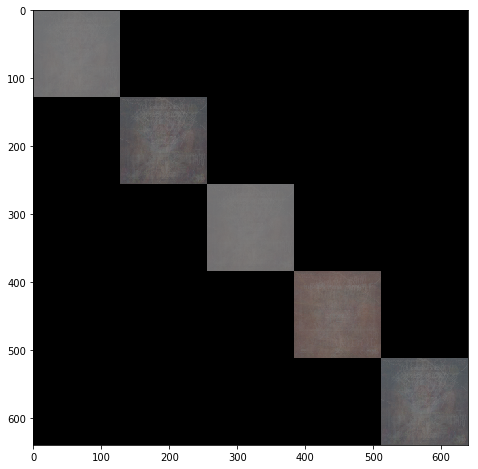

In [13]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model_2d_vae.batch_size, model_2d_vae.n_z])
x_generated = model_2d_vae.generator(z)

n = np.sqrt(model_2d_vae.batch_size).astype(np.int32)
I_generated = np.empty((img_size*n, img_size*n, 3))
#print(x_generated.shape)
for i in range(n):
    #print(i)
    I_generated[i*img_size:(i+1)*img_size, i*img_size:(i+1)*img_size, :
               ] = x_generated[i].reshape(img_size, img_size, 3)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated)

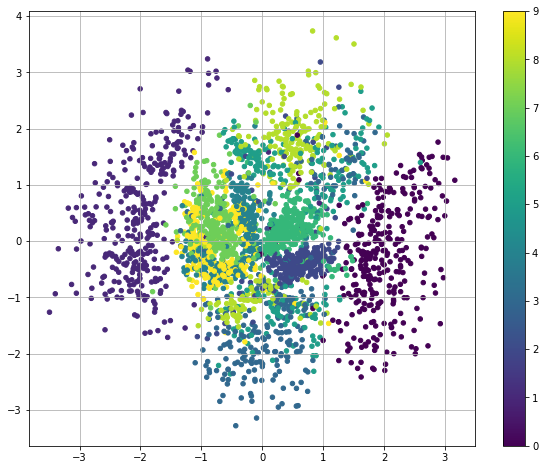

In [17]:
test_transformation(model_2d_vae, mnist)

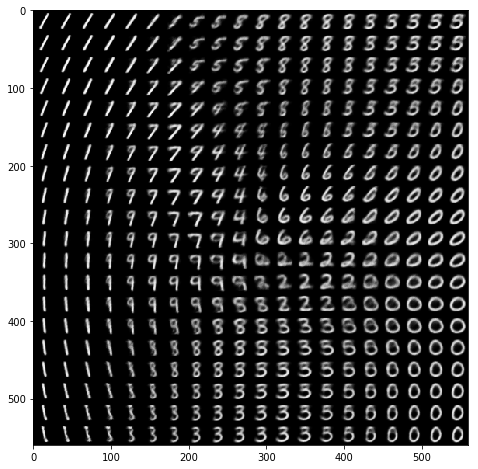

In [18]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d_vae.batch_size)
        x_hat = model_2d_vae.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")

In [57]:
samples.shape

(131, 128, 128, 3)

In [32]:
samples.reshape(-1,32*32*3)[0]

array([1., 1., 1., ..., 1., 1., 1.])

In [46]:
x_generated[0].reshape(32,32,3)

array([[[0.25060177, 0.21649554, 0.21943104],
        [0.23267081, 0.1893296 , 0.213873  ],
        [0.22454005, 0.1895237 , 0.21643785],
        ...,
        [0.22554308, 0.19459072, 0.2101453 ],
        [0.20510614, 0.18063408, 0.20656797],
        [0.20581734, 0.18714404, 0.21110952]],

       [[0.25278777, 0.2045407 , 0.21902552],
        [0.27314854, 0.21842724, 0.22755817],
        [0.29680416, 0.26125196, 0.27463317],
        ...,
        [0.23312855, 0.183905  , 0.20600018],
        [0.23832655, 0.20662591, 0.22435904],
        [0.23337123, 0.19703123, 0.22427899]],

       [[0.26310068, 0.2088291 , 0.23791721],
        [0.2714661 , 0.22727737, 0.24061891],
        [0.30821705, 0.26572558, 0.25901812],
        ...,
        [0.2540107 , 0.22802559, 0.24709964],
        [0.27491742, 0.23344165, 0.2490508 ],
        [0.24908918, 0.21130559, 0.22521517]],

       ...,

       [[0.21373066, 0.16265619, 0.19040573],
        [0.21306372, 0.16882667, 0.20818233],
        [0.2528008 , 0